## Setup, Loading Data and CDFs

In [10]:
DATA_NAME = 'pastis-full' 
TRANSFORM = 'fourier'
CHANNEL = 'gray'

In [11]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_fourier_full_pastis.ipynb


In [12]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/pastis/full/fourier/gray'

In [13]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [14]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [15]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:5]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 31800,
 3: 22260,
 4: 44520,
 5: 41340,
 6: 50880,
 7: 54060,
 8: 66780,
 9: 63600,
 10: 85860,
 11: 104940,
 12: 111300,
 13: 136740,
 14: 162180,
 15: 187620,
 16: 203520,
 17: 257580,
 18: 289380,
 19: 337080,
 20: 381600,
 21: 470640,
 22: 540600,
 23: 610560,
 24: 712320,
 25: 855420,
 26: 973080,
 27: 1154340,
 28: 1316520,
 29: 1376940,
 30: 960360,
 31: 674160,
 32: 419760,
 33: 162180}

Running 38290 CDFs


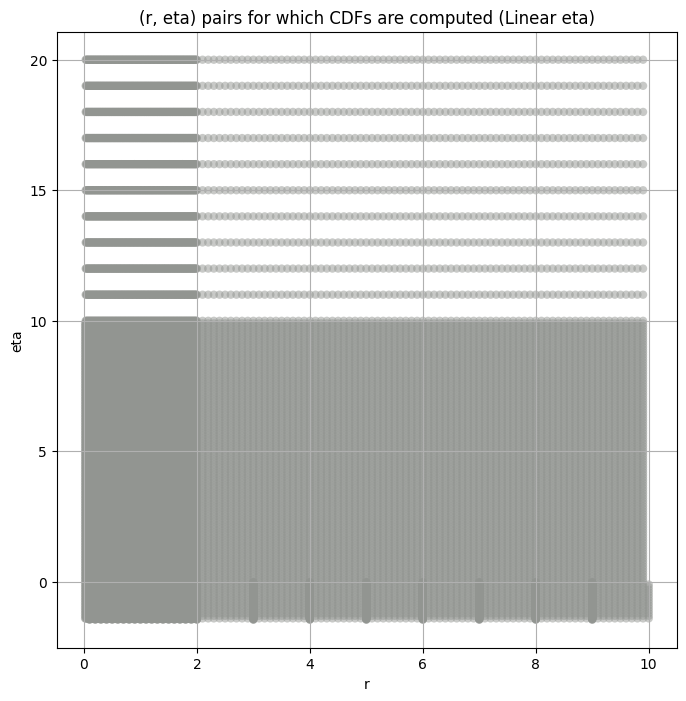

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, -1.4), <scipy.interpolate._fitpack2.In...",0.02,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,9.618487e+69,1.391529e+25
1,"((0.02, -1.3), <scipy.interpolate._fitpack2.In...",0.02,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.821735e+74,8.172634e+21
2,"((0.02, -1.2), <scipy.interpolate._fitpack2.In...",0.02,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.455488e+78,4.131785e+19
3,"((0.02, -1.1), <scipy.interpolate._fitpack2.In...",0.02,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.406735e+81,6.947275e+17
4,"((0.02, -1.0), <scipy.interpolate._fitpack2.In...",0.02,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.331443e+83,2.562075e+16


In [16]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [17]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [18]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [00:41<00:00, 2426.59it/s]


Band 5


100%|██████████| 100000/100000 [00:51<00:00, 1925.09it/s]


Band 8


100%|██████████| 100000/100000 [01:01<00:00, 1625.54it/s]


Band 11


100%|██████████| 100000/100000 [00:45<00:00, 2186.85it/s]


Band 14


100%|██████████| 100000/100000 [00:47<00:00, 2120.91it/s]


Band 17


100%|██████████| 100000/100000 [00:46<00:00, 2138.00it/s]


Band 20


100%|██████████| 100000/100000 [00:46<00:00, 2134.97it/s]


Band 23


100%|██████████| 100000/100000 [00:46<00:00, 2138.04it/s]


Band 26


100%|██████████| 100000/100000 [00:46<00:00, 2135.25it/s]


Band 29


100%|██████████| 100000/100000 [00:46<00:00, 2139.70it/s]


Band 32


100%|██████████| 100000/100000 [00:46<00:00, 2150.50it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,10.134422,9.643435,10.646572,1.621352,1.183683,2.159779,31800.0
5,5.424390,5.164831,5.694692,1.556881,1.034867,2.247035,41340.0
8,2.974848,2.833664,3.120628,1.541575,1.065818,2.175573,66780.0
11,1.695055,1.610400,1.784300,1.922300,1.152667,3.322009,104940.0
14,0.926228,0.881725,0.973125,1.705795,1.083743,3.005845,162180.0
17,0.518186,0.492855,0.544779,1.771588,1.108579,3.490519,257580.0
20,0.260627,0.247789,0.274535,1.956200,1.143715,5.900508,381600.0
23,0.122159,0.116055,0.128693,2.041856,1.252694,3.881752,610560.0
26,0.049178,0.046151,0.053056,5.035482,1.824682,19.982931,973080.0


## Initial Grid Search and Hypothesis Test Plots

In [19]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [20]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr

augmented_var_df.to_csv(augmented_var_df_path)
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,10.134422,10.134422,9.782848,9.546412,9.353152,9.182628,8.889160,8.640179,8.418350,8.217493,8.032310,7.546413
5,5.424390,5.424390,5.263988,5.168985,5.086771,5.014502,4.888740,4.776872,4.675648,4.582586,4.496524,4.266775
8,2.974848,2.974848,2.915290,2.875796,2.842202,2.812102,2.758150,2.710953,2.668601,2.629780,2.593668,2.497113
11,1.695055,1.695055,1.663257,1.645027,1.629946,1.616589,1.593062,1.572441,1.553386,1.535631,1.518962,1.474134
14,0.926228,0.926228,0.911027,0.901737,0.893657,0.886373,0.873591,0.862387,0.852188,0.842727,0.833824,0.809826
17,0.518186,0.518186,0.509296,0.503911,0.499483,0.495506,0.488453,0.482207,0.476513,0.471247,0.466325,0.453006
20,0.260627,0.260627,0.256206,0.253544,0.251270,0.249237,0.245621,0.242386,0.239438,0.236714,0.234168,0.227321
23,0.122159,0.122159,0.119913,0.118575,0.117447,0.116448,0.114696,0.113161,0.111766,0.110477,0.109277,0.106054
26,0.049178,0.049178,0.047630,0.046923,0.046376,0.045902,0.045096,0.044404,0.043791,0.043232,0.042716,0.041357


####
Band  2


100%|██████████| 38290/38290 [00:45<00:00, 849.90it/s]


Finding Minimum after computing 38290 CDFs
2 0 0.00345553620314043 10.134422


100%|██████████| 38290/38290 [00:42<00:00, 893.85it/s]


Finding Minimum after computing 38290 CDFs
2 25 0.0034202256393036645 9.782848


100%|██████████| 38290/38290 [00:42<00:00, 898.26it/s]


Finding Minimum after computing 38290 CDFs
2 50 0.0034528621884527544 9.546412


100%|██████████| 38290/38290 [00:42<00:00, 897.33it/s]


Finding Minimum after computing 38290 CDFs
2 75 0.004173855926471633 9.353152
Number of samples: 31800, Without approximation : 31800.0


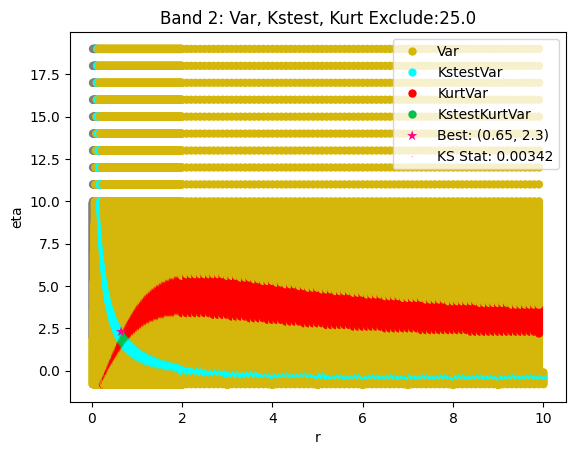

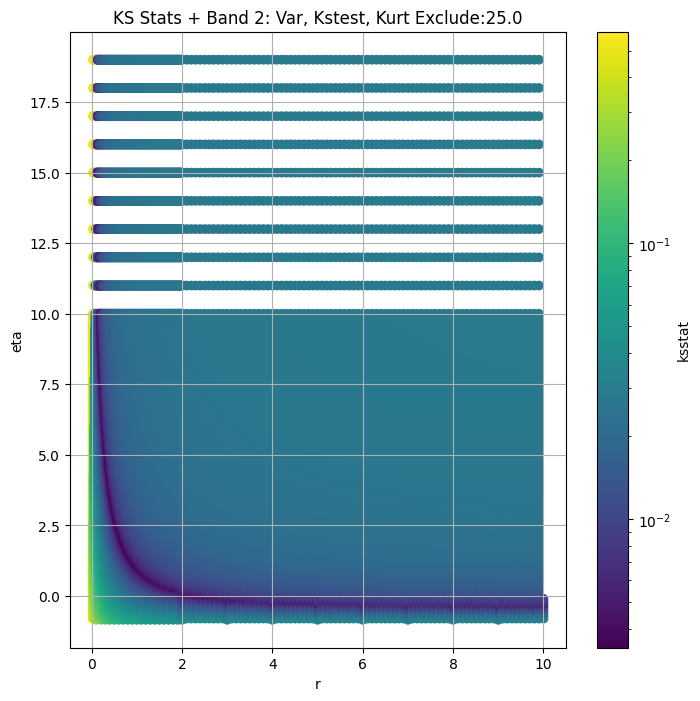

####
Band  5


100%|██████████| 38290/38290 [00:54<00:00, 698.27it/s]


Finding Minimum after computing 38290 CDFs
5 0 0.002581238246075257 5.42439


100%|██████████| 38290/38290 [00:54<00:00, 699.31it/s]


Finding Minimum after computing 38290 CDFs
5 25 0.0025584110442049557 5.2639885


100%|██████████| 38290/38290 [00:54<00:00, 697.63it/s]


Finding Minimum after computing 38290 CDFs
5 50 0.0031266656495148037 5.168985


100%|██████████| 38290/38290 [00:54<00:00, 700.20it/s]


Finding Minimum after computing 38290 CDFs
5 75 0.003784754593148809 5.086771
Number of samples: 41340, Without approximation : 41340.0


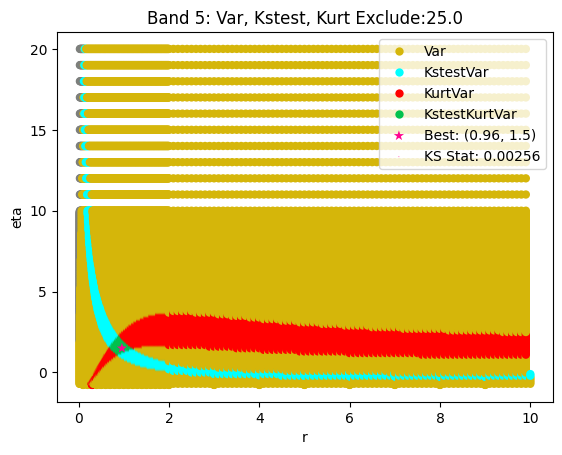

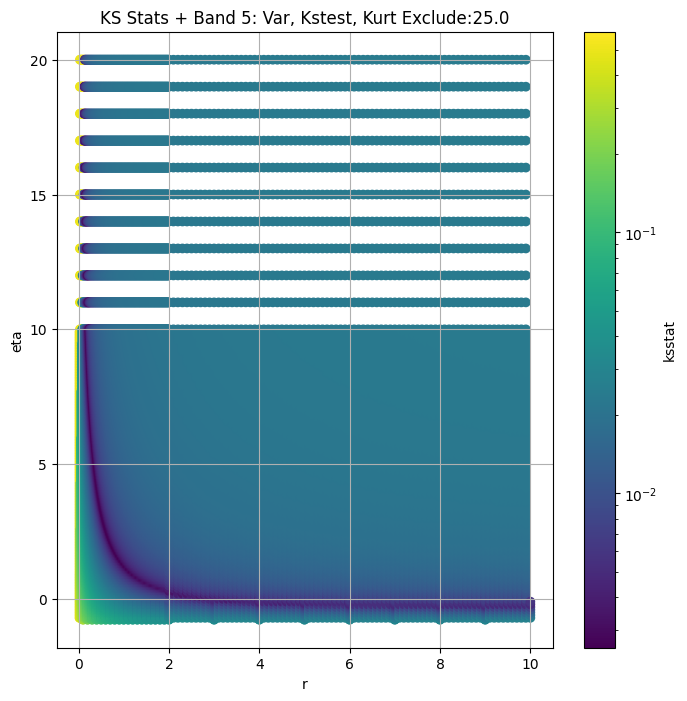

####
Band  8


100%|██████████| 38290/38290 [01:27<00:00, 438.56it/s]


Finding Minimum after computing 38290 CDFs
8 0 0.0032486325728807164 2.9748478


100%|██████████| 38290/38290 [01:27<00:00, 438.81it/s]


Finding Minimum after computing 38290 CDFs
8 25 0.0031882767625054376 2.9152899


100%|██████████| 38290/38290 [01:30<00:00, 424.55it/s]


Finding Minimum after computing 38290 CDFs
8 50 0.003162117206958359 2.8757958


100%|██████████| 38290/38290 [01:26<00:00, 441.06it/s]


Finding Minimum after computing 38290 CDFs
8 75 0.003169311349132564 2.8422022


100%|██████████| 38290/38290 [01:26<00:00, 441.79it/s]


Finding Minimum after computing 38290 CDFs
8 100 0.003264506241545728 2.812102
Number of samples: 66780, Without approximation : 66780.0


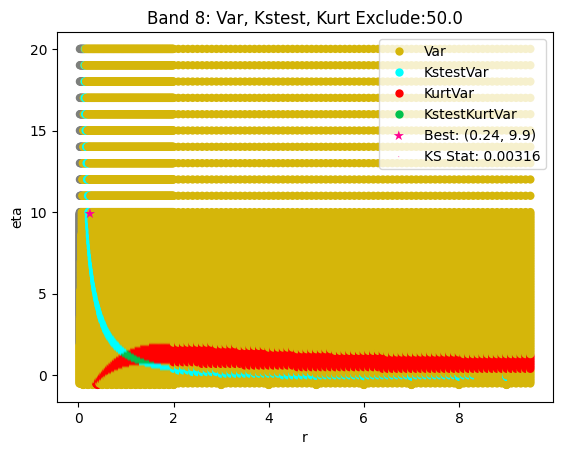

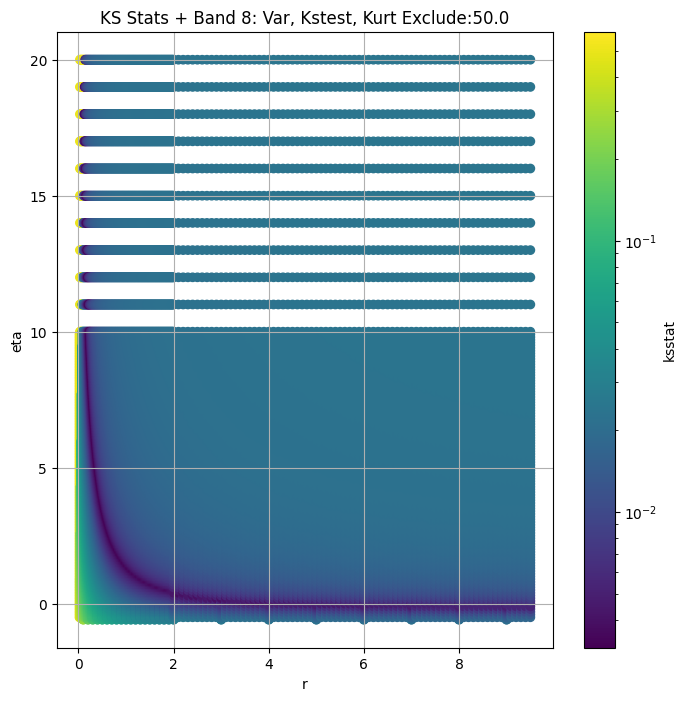

####
Band  11


100%|██████████| 38290/38290 [02:10<00:00, 292.30it/s]


Finding Minimum after computing 38290 CDFs
11 0 0.001689866134036433 1.6950549


100%|██████████| 38290/38290 [02:10<00:00, 292.99it/s]


Finding Minimum after computing 38290 CDFs
11 25 0.0016630867566810315 1.6632574


100%|██████████| 38290/38290 [02:07<00:00, 301.03it/s]


Finding Minimum after computing 38290 CDFs
11 50 0.0016608568295888304 1.6450269


100%|██████████| 38290/38290 [02:06<00:00, 301.55it/s]


Finding Minimum after computing 38290 CDFs
11 75 0.0016732999230049117 1.6299461


100%|██████████| 38290/38290 [02:06<00:00, 301.92it/s]


Finding Minimum after computing 38290 CDFs
11 100 0.0018493327045981944 1.6165886
Number of samples: 100000, Without approximation : 104940.0


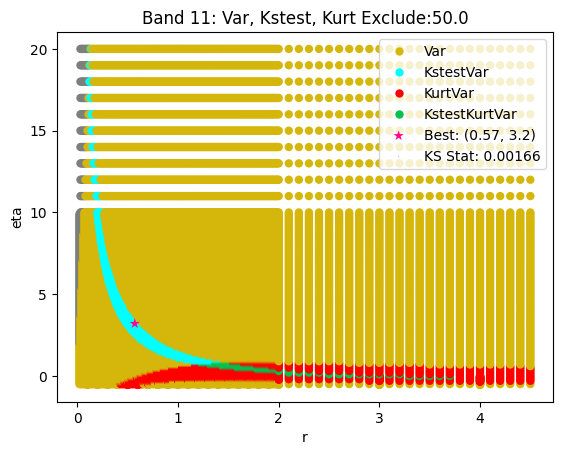

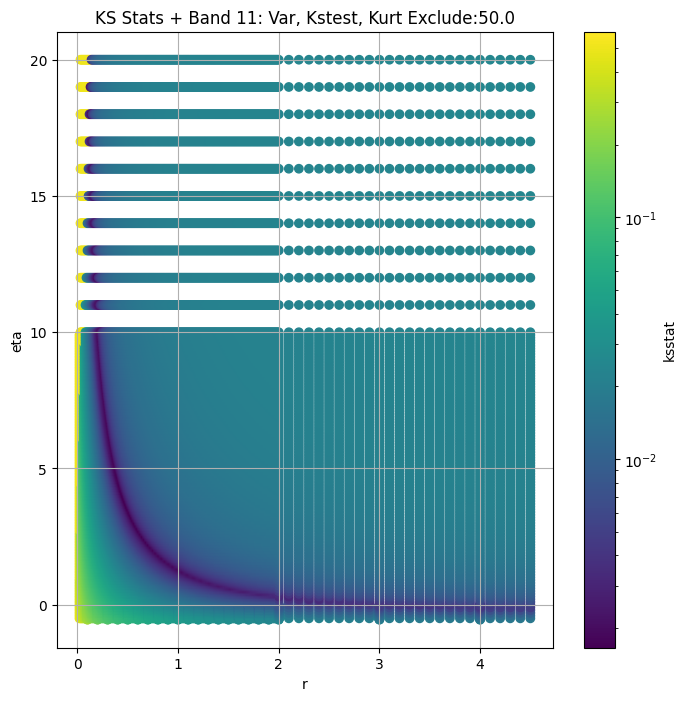

####
Band  14


100%|██████████| 38290/38290 [02:08<00:00, 297.37it/s]


Finding Minimum after computing 38290 CDFs
14 0 0.00260495959174184 0.92622846


100%|██████████| 38290/38290 [02:12<00:00, 288.02it/s]


Finding Minimum after computing 38290 CDFs
14 25 0.002581581821886225 0.91102684


100%|██████████| 38290/38290 [02:06<00:00, 301.68it/s]


Finding Minimum after computing 38290 CDFs
14 50 0.00255477177809299 0.901737


100%|██████████| 38290/38290 [02:08<00:00, 298.20it/s]


Finding Minimum after computing 38290 CDFs
14 75 0.002540166522405518 0.89365673


100%|██████████| 38290/38290 [02:11<00:00, 290.90it/s]


Finding Minimum after computing 38290 CDFs
14 100 0.002525933929327151 0.88637304


100%|██████████| 38290/38290 [02:07<00:00, 299.56it/s]


Finding Minimum after computing 38290 CDFs
14 150 0.0029191068330191652 0.87359095


100%|██████████| 38290/38290 [02:09<00:00, 294.68it/s]


Finding Minimum after computing 38290 CDFs
14 200 0.0034930382432195248 0.86238706
Number of samples: 100000, Without approximation : 162180.0


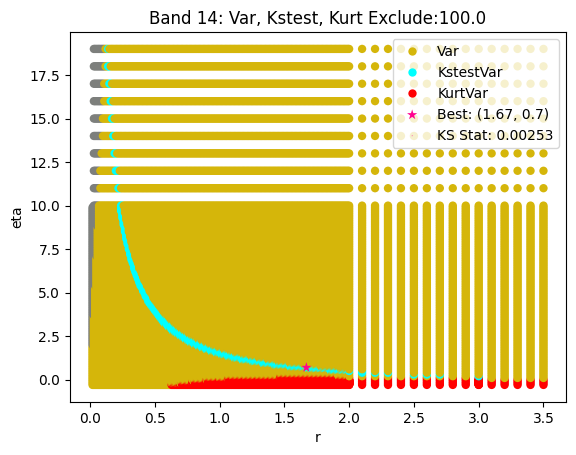

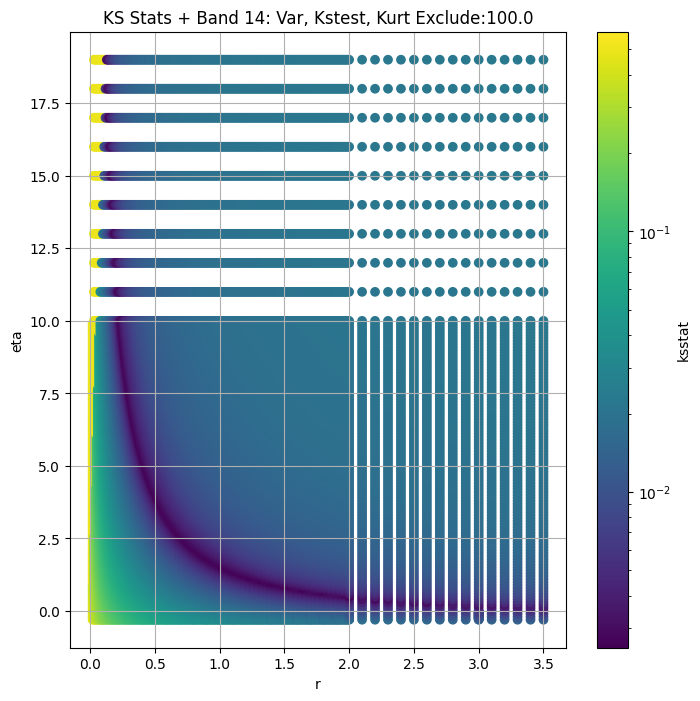

####
Band  17


100%|██████████| 38290/38290 [02:04<00:00, 307.93it/s]


Finding Minimum after computing 38290 CDFs
17 0 0.0007792027874289342 0.51818645


100%|██████████| 38290/38290 [02:04<00:00, 307.70it/s]


Finding Minimum after computing 38290 CDFs
17 25 0.0007099279283180326 0.50929636


100%|██████████| 38290/38290 [02:04<00:00, 308.11it/s]


Finding Minimum after computing 38290 CDFs
17 50 0.0010990775661468 0.5039107


100%|██████████| 38290/38290 [02:04<00:00, 307.96it/s]


Finding Minimum after computing 38290 CDFs
17 75 0.0014877707947384966 0.4994832
Number of samples: 100000, Without approximation : 257580.0


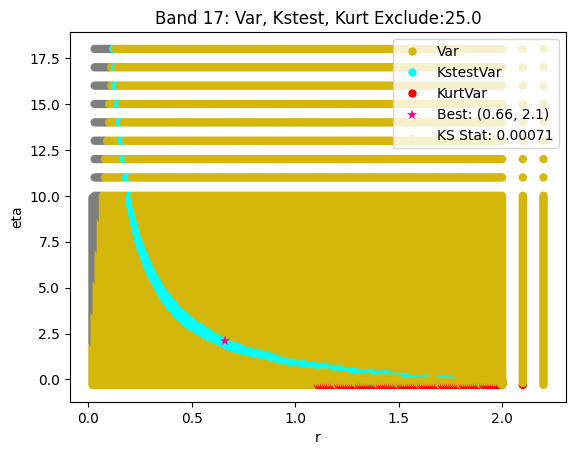

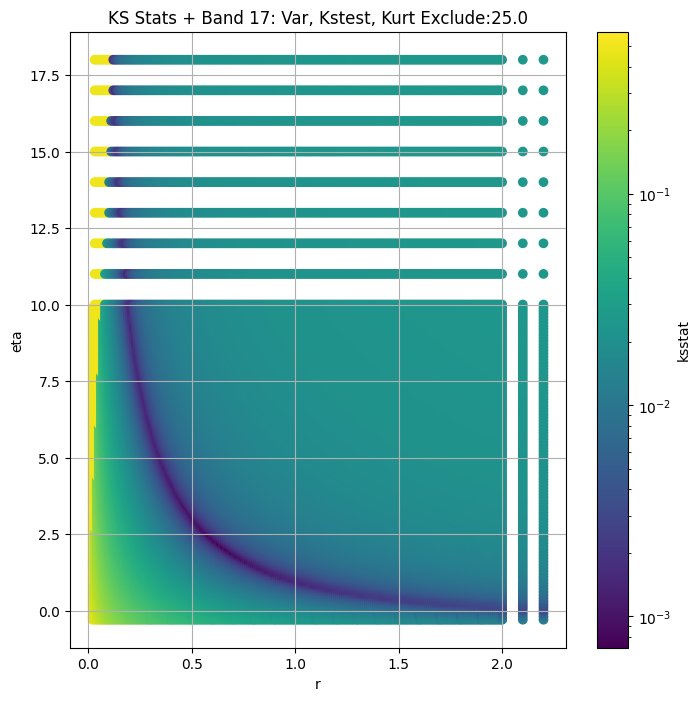

####
Band  20


100%|██████████| 38290/38290 [02:04<00:00, 308.58it/s]


Finding Minimum after computing 38290 CDFs
20 0 0.0008110924316008239 0.26062724


100%|██████████| 38290/38290 [02:03<00:00, 310.34it/s]


Finding Minimum after computing 38290 CDFs
20 25 0.0007800755391313696 0.2562057


100%|██████████| 38290/38290 [02:04<00:00, 307.09it/s]


Finding Minimum after computing 38290 CDFs
20 50 0.0010534021439085883 0.2535443


100%|██████████| 38290/38290 [02:04<00:00, 307.99it/s]


Finding Minimum after computing 38290 CDFs
20 75 0.0013386485298664264 0.25126967
Number of samples: 100000, Without approximation : 381600.0


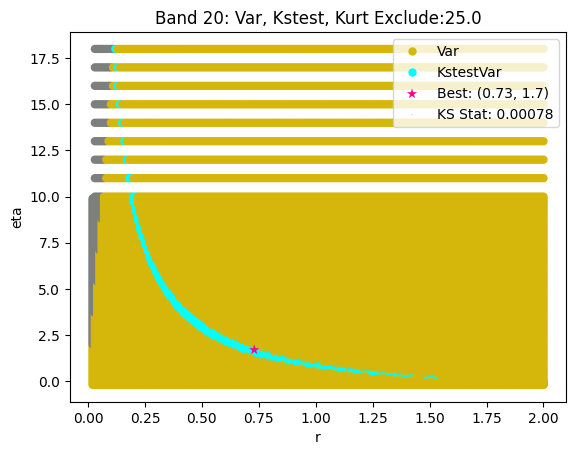

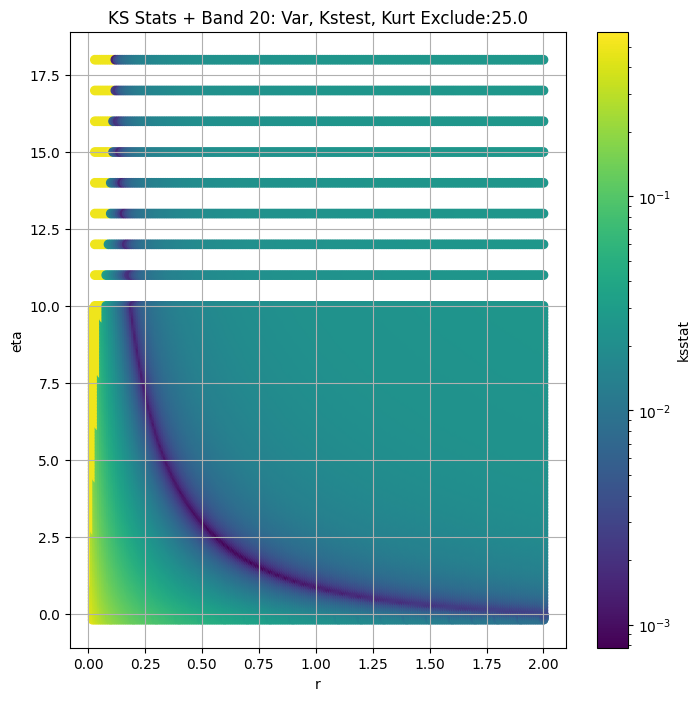

####
Band  23


100%|██████████| 38290/38290 [02:04<00:00, 308.62it/s]


Finding Minimum after computing 38290 CDFs
23 0 0.001493255361658119 0.12215869


100%|██████████| 38290/38290 [02:04<00:00, 307.87it/s]


Finding Minimum after computing 38290 CDFs
23 25 0.0014527183028435475 0.11991333


100%|██████████| 38290/38290 [02:10<00:00, 292.90it/s]


Finding Minimum after computing 38290 CDFs
23 50 0.0014318631131532977 0.11857531


100%|██████████| 38290/38290 [02:14<00:00, 284.24it/s]


Finding Minimum after computing 38290 CDFs
23 75 0.0014628353169907626 0.117447


100%|██████████| 38290/38290 [02:08<00:00, 298.05it/s]


Finding Minimum after computing 38290 CDFs
23 100 0.0017799822933824982 0.11644758
Number of samples: 100000, Without approximation : 610560.0


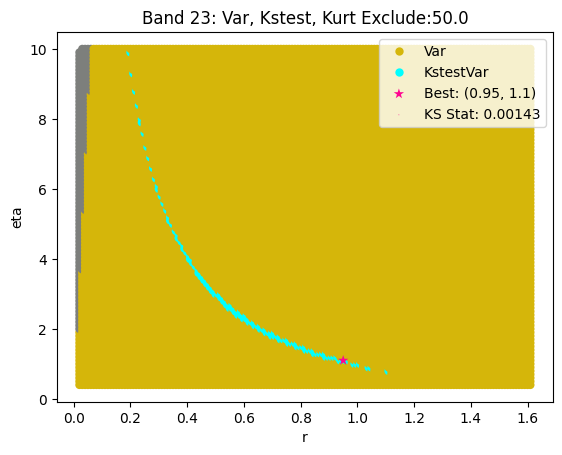

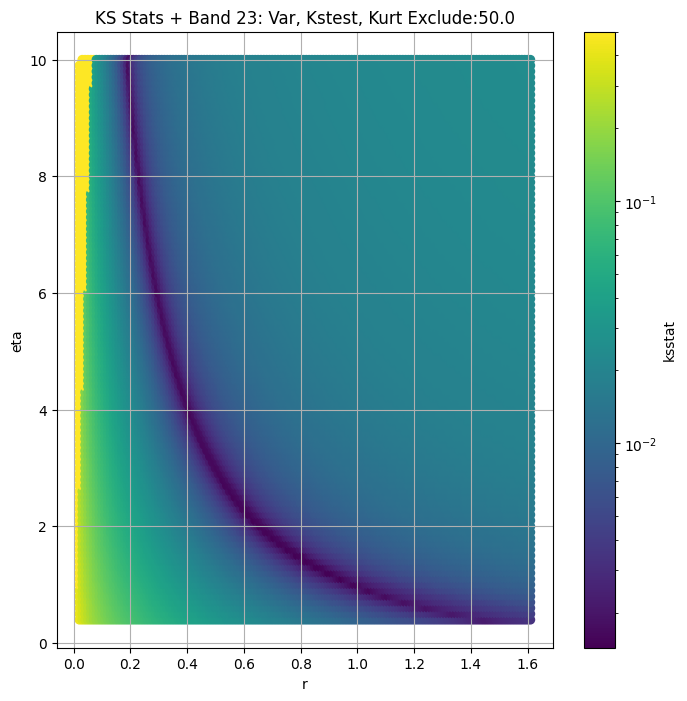

####
Band  26


100%|██████████| 38290/38290 [02:06<00:00, 303.09it/s]


Finding Minimum after computing 38290 CDFs
26 0 0.002096848832161699 0.04917801


100%|██████████| 38290/38290 [02:10<00:00, 293.55it/s]


Finding Minimum after computing 38290 CDFs
26 25 0.0007504780114354626 0.04763038


100%|██████████| 38290/38290 [02:14<00:00, 285.44it/s]


Finding Minimum after computing 38290 CDFs
26 50 0.0008243232055004102 0.046922714


100%|██████████| 38290/38290 [02:19<00:00, 275.09it/s]


Finding Minimum after computing 38290 CDFs
26 75 0.0011683099038561906 0.046375502
Number of samples: 100000, Without approximation : 973080.0


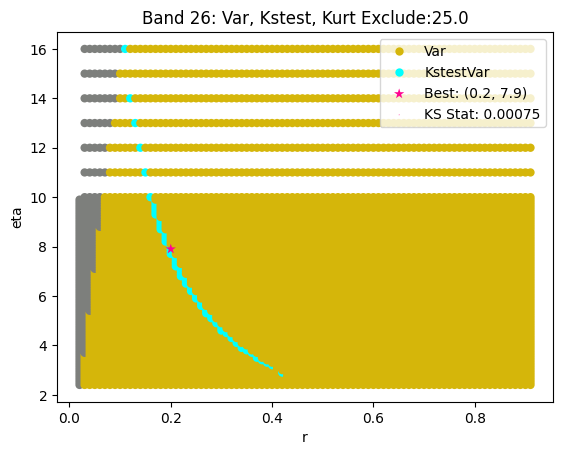

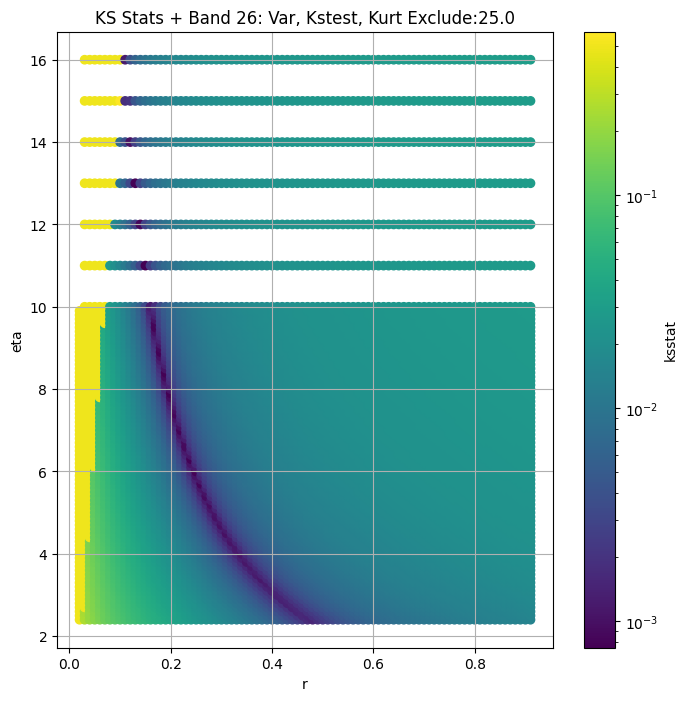

####
Band  29


100%|██████████| 38290/38290 [02:11<00:00, 291.98it/s]


Finding Minimum after computing 38290 CDFs
29 0 0.007042235706954572 0.01554814


100%|██████████| 38290/38290 [02:10<00:00, 292.56it/s]


Finding Minimum after computing 38290 CDFs
29 25 0.004001905755952717 0.014465072


100%|██████████| 38290/38290 [02:13<00:00, 286.49it/s]


Finding Minimum after computing 38290 CDFs
29 50 0.002752689958154919 0.014051098


100%|██████████| 38290/38290 [02:08<00:00, 297.66it/s]


Finding Minimum after computing 38290 CDFs
29 75 0.00186924546552103 0.013758862


100%|██████████| 38290/38290 [02:14<00:00, 284.26it/s]


Finding Minimum after computing 38290 CDFs
29 100 0.001629964956930463 0.0135306865


100%|██████████| 38290/38290 [02:09<00:00, 296.14it/s]


Finding Minimum after computing 38290 CDFs
29 150 0.002070354182437062 0.013175184


100%|██████████| 38290/38290 [02:09<00:00, 295.02it/s]


Finding Minimum after computing 38290 CDFs
29 200 0.0026099890341167997 0.012895831
Number of samples: 100000, Without approximation : 1376940.0


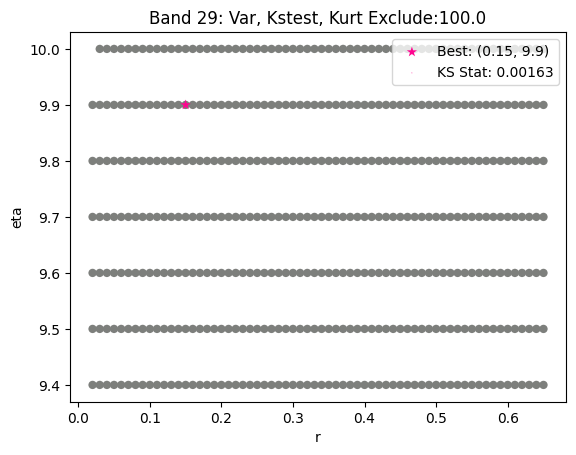

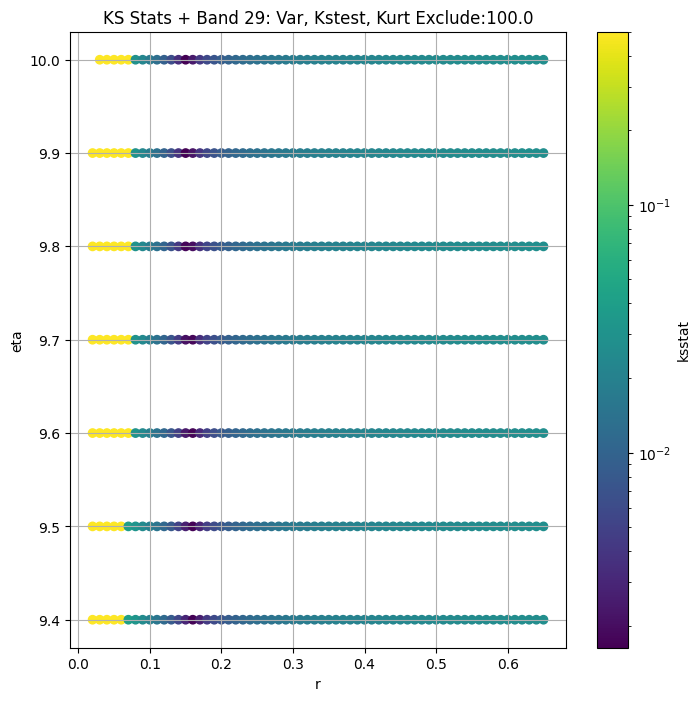

####
Band  32


100%|██████████| 38290/38290 [02:15<00:00, 281.85it/s]


Finding Minimum after computing 38290 CDFs
32 0 0.0013801913606155125 0.0013369159


100%|██████████| 38290/38290 [02:13<00:00, 285.95it/s]


Finding Minimum after computing 38290 CDFs
32 25 0.0013758632144259542 0.0013176324


100%|██████████| 38290/38290 [02:09<00:00, 296.09it/s]


Finding Minimum after computing 38290 CDFs
32 50 0.0013717551096109615 0.001304606


100%|██████████| 38290/38290 [02:23<00:00, 266.74it/s]


Finding Minimum after computing 38290 CDFs
32 75 0.0016475954676504756 0.001293449


100%|██████████| 38290/38290 [02:11<00:00, 290.16it/s]


Finding Minimum after computing 38290 CDFs
32 100 0.0019848190183624492 0.0012835086
Number of samples: 100000, Without approximation : 419760.0


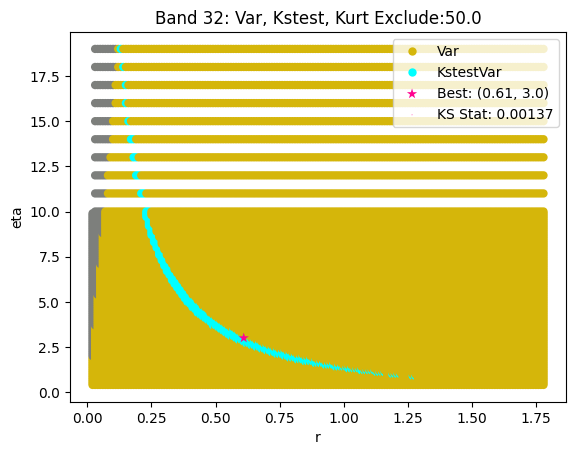

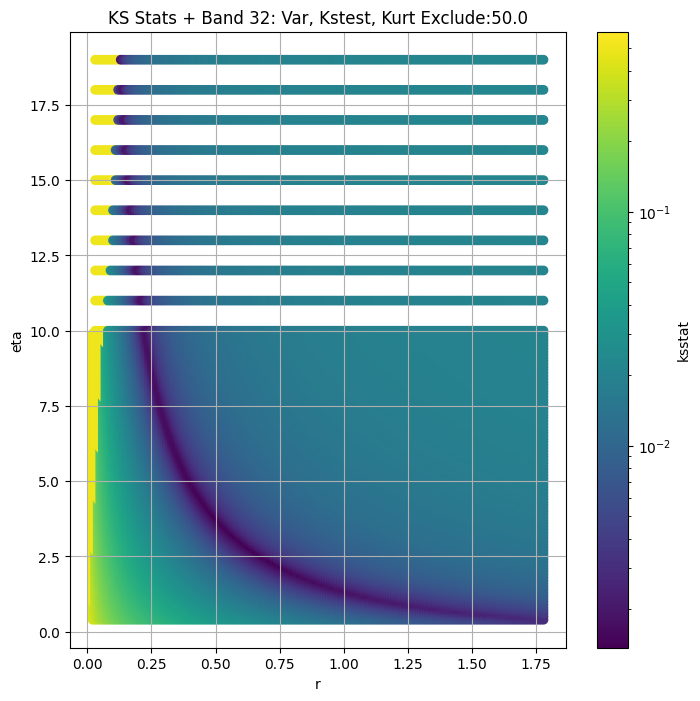

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,10.134422,9.643435,10.646572,1.621352,1.183683,2.159779,31800.0,0.003420,0.65,2.3,6.047838e-01,25.0,9.782848,0.007611
5,5.424390,5.164831,5.694692,1.556881,1.034867,2.247035,41340.0,0.002558,0.96,1.5,1.595882e+00,25.0,5.263988,0.006675
8,2.974848,2.833664,3.120628,1.541575,1.065818,2.175573,66780.0,0.003162,0.24,9.9,2.592458e-07,50.0,2.875796,0.005253
11,1.695055,1.610400,1.784300,1.922300,1.152667,3.322009,104940.0,0.001661,0.57,3.2,3.763327e-02,50.0,1.645027,0.004191
14,0.926228,0.881725,0.973125,1.705795,1.083743,3.005845,162180.0,0.002526,1.67,0.7,8.200219e-01,100.0,0.886373,0.003371
17,0.518186,0.492855,0.544779,1.771588,1.108579,3.490519,257580.0,0.000710,0.66,2.1,3.642474e-02,25.0,0.509296,0.002675
20,0.260627,0.247789,0.274535,1.956200,1.143715,5.900508,381600.0,0.000780,0.73,1.7,3.205011e-02,25.0,0.256206,0.002198
23,0.122159,0.116055,0.128693,2.041856,1.252694,3.881752,610560.0,0.001432,0.95,1.1,4.070269e-02,50.0,0.118575,0.001738
26,0.049178,0.046151,0.053056,5.035482,1.824682,19.982931,973080.0,0.000750,0.20,7.9,1.689696e-10,25.0,0.047630,0.001377


In [21]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1
        no_improvement_counter = 0

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]

            if no_improvement_counter > 1:
                break

            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if min_stat < master_df.loc[group, 'kstest_stat_initial']:
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
            else:
                no_improvement_counter += 1
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

In [22]:
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500,kstest_stat_0,kstest_stat_25,kstest_stat_50,kstest_stat_75,kstest_stat_100,kstest_stat_150,kstest_stat_200
band,,,,,,,,,,,,,,,,,,,
2,10.134422,10.134422,9.782848,9.546412,9.353152,9.182628,8.889160,8.640179,8.418350,8.217493,8.032310,7.546413,0.003456,0.003420,0.003453,0.004174,NaN,NaN,NaN
5,5.424390,5.424390,5.263988,5.168985,5.086771,5.014502,4.888740,4.776872,4.675648,4.582586,4.496524,4.266775,0.002581,0.002558,0.003127,0.003785,NaN,NaN,NaN
8,2.974848,2.974848,2.915290,2.875796,2.842202,2.812102,2.758150,2.710952,2.668601,2.629780,2.593668,2.497113,0.003249,0.003188,0.003162,0.003169,0.003265,NaN,NaN
11,1.695055,1.695055,1.663257,1.645027,1.629946,1.616589,1.593062,1.572441,1.553386,1.535631,1.518962,1.474134,0.001690,0.001663,0.001661,0.001673,0.001849,NaN,NaN
14,0.926228,0.926228,0.911027,0.901737,0.893657,0.886373,0.873591,0.862387,0.852188,0.842727,0.833824,0.809826,0.002605,0.002582,0.002555,0.002540,0.002526,0.002919,0.003493
17,0.518186,0.518186,0.509296,0.503911,0.499483,0.495506,0.488453,0.482207,0.476513,0.471247,0.466325,0.453006,0.000779,0.000710,0.001099,0.001488,NaN,NaN,NaN
20,0.260627,0.260627,0.256206,0.253544,0.251270,0.249237,0.245621,0.242386,0.239438,0.236714,0.234168,0.227321,0.000811,0.000780,0.001053,0.001339,NaN,NaN,NaN
23,0.122159,0.122159,0.119913,0.118575,0.117447,0.116448,0.114696,0.113161,0.111766,0.110477,0.109277,0.106054,0.001493,0.001453,0.001432,0.001463,0.001780,NaN,NaN
26,0.049178,0.049178,0.047630,0.046923,0.046376,0.045902,0.045096,0.044404,0.043791,0.043232,0.042716,0.041357,0.002097,0.000750,0.000824,0.001168,NaN,NaN,NaN


## Optimization

In [23]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

In [24]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

SKIP_OPTIMIZE_STEP = True
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(-50, 51, 10)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, f'best_r'] = master_df['initial_r']
            master_df.loc[group, f'best_eta'] = master_df['initial_eta']
            master_df.loc[group, f'best_scale'] = master_df['initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']

                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                group_cdfs = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                group_cdfs_df = create_kurt_var_ksstat_df(group_cdfs)

                for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                    exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                    
                    if exclude_cutoff == 0:
                        augmented_var = np.var(group_data_map[group])
                    else:
                        augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                    group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                    ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                    
                    cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                    augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                    group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                    
                    print(group, adjust_exclude_cutoff, exclude_cutoff, min_stat, augmented_var, cutoff_label)
                    best_adjust = 0

                    if min_stat < master_df.loc[group, 'kstest_stat_best']:

                        inital_min_stat = min_stat
                        inital_best_param = initial_param
                        master_df.loc[group, 'kstest_stat_best'] = min_stat
                        initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                        master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                        master_df.loc[group, 'best_scale'] = initial_scale
                        master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                        master_df.loc[group, 'best_augmented_var'] = augmented_var
                        augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                        best_adjust = adjust_exclude_cutoff

                cutoff_label = generate_cutoff_label(best_adjust)
                ksstats = group_cdfs_df[f"ksstat_exclude_{best_adjust}"]
                
                print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
                
                cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
                master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

                best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

                group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
                group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

                group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

                group_dict = rEtaKsstats_dict[group]
                group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
                rEtaKsstats_dict[group] = group_dict

                print(f"Iter {d} {GROUP} {group} best parameters: {master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'], master_df.loc[group, 'best_scale'], master_df.loc[group, 'best_exclude_cutoff'], master_df.loc[group, f'kstest_stat_best']}")

            filtered_df = group_cdfs_df[(group_cdfs_df['r'] > master_df.loc[group, 'initial_r'] - r_granularity) & 
                            (group_cdfs_df['r'] < master_df.loc[group, 'initial_r'] + r_granularity) &
                            (group_cdfs_df['eta'] > master_df.loc[group, 'initial_eta'] - eta_granularity) &
                            (group_cdfs_df['eta'] < master_df.loc[group, 'initial_eta'] + eta_granularity)]
            
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

KeyError: "['best_exclude_cutoff'] not in index"

## Comparing Empirical and Computed CDF/PDF

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df

In [ ]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))